Start with each college, compared to national, for all years: t-test for proportions\
Each college, compared to its local, for all years: t-test for all proportions


In [71]:
%pip install scipy
%pip install statsmodels

from scipy.stats import ttest_rel, ttest_ind, spearmanr
from statsmodels.stats.multitest import multipletests
import pandas as pd


[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
jobs = pd.read_csv('jobs.csv')
colleges = pd.read_csv('colleges.csv')

colleges.rename(columns={'Category': 'Major Field'}, inplace=True)

total_employment_dict = jobs[jobs['Occupation Title'] == 'All Occupations'].set_index(['Year', 'Area'])['Total Employment'].to_dict()
total_employment_dict = jobs[jobs['Occupation Title'] == 'All Occupations'].groupby('Year')['Total Employment'].sum().to_dict()

def calculate_proportion(row):
    key = (row['Year'])
    if key in total_employment_dict:
        # print(f"Key: {key}, Total Employment: {total_employment_dict[key]}, Row Employment: {row['Total Employment']}, proportion: {row['Total Employment'] / total_employment_dict[key]}")
        return row['Total Employment'] / total_employment_dict[key]
    else:
        print(f"Key not found: {key}")
        return None

def sum_employment_by_major(job_df):
    employment_df = pd.DataFrame(columns=['Major Field', 'Total Employment', 'Proportions'])
    for index, row in job_df.iterrows():
        major = row['Major Field']
        employment = row['Total Employment']
        proportion = row['Proportions']
        
        if major in employment_df['Major Field'].values:
            employment_df.loc[employment_df['Major Field'] == major, 'Total Employment'] += employment
            employment_df.loc[employment_df['Major Field'] == major, 'Proportions'] += proportion
        else:
            employment_df.loc[len(employment_df)] = {'Major Field': major, 'Total Employment': employment, 'Proportions': proportion}
    return employment_df

def compare_job_to_college(jobs, colleges, college, college_year, job_year, area):
    initial_p_values = []
    if area == 'all':
        jobs = jobs[jobs['Occupation Group'] != ""]
        jobs['Proportions'] = jobs.apply(calculate_proportion, axis=1)
        job_df = jobs[jobs['Year'] == job_year]
    else:
        jobs = jobs[jobs['Occupation Group'] == 'major']
        job_df = jobs[(jobs['Year'] == job_year) & (jobs['Area'] == area)]
    college_df = colleges[(colleges['Year'] == college_year) & (colleges['College'] == college)]
    job_employment_df = sum_employment_by_major(job_df)
    job_employment_df['Proportions'] *= 100
    combined_df = pd.merge(job_employment_df, college_df, on='Major Field')
    _, p = ttest_rel(combined_df['Proportions'], combined_df['Bachelors'])
    return p
    
college_to_area_map = {
    'ucsd': "San Diego-Carlsbad, CA",
    'asu': "Winston-Salem, NC",
    'colgate': "Utica-Rome, NY",
    'dartmouth': "West Central-Southwest New Hampshire nonmetropolitan area",
    'caltech': "Los Angeles-Long Beach-Anaheim, CA",
    'george': "Washington-Arlington-Alexandria, DC-VA-MD-WV Metropolitan Division",
    'umich': "Ann Arbor, MI",
    'wsu': "Spokane-Spokane Valley, WA"
}

p_value_df = pd.DataFrame(columns=['College', 'College Year', 'Job Year', 'Area', 'P-Value'])
for key in college_to_area_map.keys():
    for year in range(2014, 2023):
        for area in ['all', college_to_area_map[key]]:
            for i in range(-6, 1):
                if year + i in range(2014, 2023):
                    college_year = year
                    job_year = year + i
                    p_value = compare_job_to_college(jobs, colleges, key, college_year, job_year, area)
                    p_value_df.loc[len(p_value_df)] = {'College': key, 'College Year': college_year, 'Job Year': job_year, 'Area': area, 'P-Value': p_value}

print(p_value_df)
    

/var/folders/_n/cr1b7bs150966hbbw84jhb9m0000gn/T/ipykernel_25841/2998260571.py:45: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  _, p = ttest_rel(combined_df['Proportions'], combined_df['Bachelors'])
/var/folders/_n/cr1b7bs150966hbbw84jhb9m0000gn/T/ipykernel_25841/2998260571.py:45: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  _, p = ttest_rel(combined_df['Proportions'], combined_df['Bachelors'])
/var/folders/_n/cr1b7bs150966hbbw84jhb9m0000gn/T/ipykernel_25841/2998260571.py:45: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  _, p = ttest_rel(combined_df['Proportions'], combined_df['Bachelors'])
/var/folders/_n/cr1b7bs150966hbbw84jhb9m0000gn/T/ipykernel_25841/2998260571.py:45: SmallSampleWarnin

    College  College Year  Job Year                        Area   P-Value
0      ucsd          2014      2014                         all  0.532491
1      ucsd          2014      2014      San Diego-Carlsbad, CA  0.928645
2      ucsd          2015      2014                         all  0.420189
3      ucsd          2015      2015                         all  0.418257
4      ucsd          2015      2014      San Diego-Carlsbad, CA  0.885554
..      ...           ...       ...                         ...       ...
667     wsu          2022      2018  Spokane-Spokane Valley, WA  0.029370
668     wsu          2022      2019  Spokane-Spokane Valley, WA  0.022628
669     wsu          2022      2020  Spokane-Spokane Valley, WA  0.031573
670     wsu          2022      2021  Spokane-Spokane Valley, WA  0.027610
671     wsu          2022      2022  Spokane-Spokane Valley, WA  0.017631

[672 rows x 5 columns]


In [70]:
# write to csv so other people don't have to run 13 mins of code
p_value_df.to_csv('p_value.csv', index=False)

for index, row in p_value_df.iterrows():
    if row['P-Value'] < 0.05:
        print(f"School: {row['College']}, College Year: {row['College Year']}, Job Year: {row['Job Year']}, Area: {row['Area']}, P-Value: {row['P-Value']}")

School: asu, College Year: 2014, Job Year: 2014, Area: all, P-Value: 0.03422275818569788
School: asu, College Year: 2015, Job Year: 2014, Area: all, P-Value: 0.031035952034727875
School: asu, College Year: 2015, Job Year: 2015, Area: all, P-Value: 0.028938785201141147
School: asu, College Year: 2016, Job Year: 2014, Area: all, P-Value: 0.030959117051959573
School: asu, College Year: 2016, Job Year: 2015, Area: all, P-Value: 0.02890189409934173
School: asu, College Year: 2016, Job Year: 2016, Area: all, P-Value: 0.027722590665938504
School: asu, College Year: 2017, Job Year: 2014, Area: all, P-Value: 0.0280103213611815
School: asu, College Year: 2017, Job Year: 2015, Area: all, P-Value: 0.026094727442643347
School: asu, College Year: 2017, Job Year: 2016, Area: all, P-Value: 0.024999402447118575
School: asu, College Year: 2017, Job Year: 2017, Area: all, P-Value: 0.022530846477859818
School: asu, College Year: 2018, Job Year: 2014, Area: all, P-Value: 0.02532943778290955
School: asu, Co

In [69]:
# Bonferroni Correction is most likely not needed because we can manually adjust for false positives
for college in p_value_df['College'].unique():
    p_value_list = p_value_df[p_value_df['College'] == college]
    rejected, p_adjusted, _, _ = multipletests(p_value_list['P-Value'], alpha=0.05, method='holm')
    print(f"{college}: {rejected}")
    for i in range(len(rejected)):
        if rejected[i]:
            print(f"School: {p_value_list.iloc[i]['College']}, College Year: {p_value_list.iloc[i]['College Year']}, Job Year: {p_value_list.iloc[i]['Job Year']}, Area: {p_value_list.iloc[i]['Area']}, P-Value: {p_value_list.iloc[i]['P-Value']}")
rejected, p_adjusted, _, _ = multipletests(p_value_df['P-Value'], alpha=0.05, method='holm')
print(rejected)

ucsd: [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False]
asu: [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False Fa

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.0/165.0 kB 3.7 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 9.1 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.5/254.5 kB 13.4 MB/s eta 0:00:00
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 9.4 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.3/64.3 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 13.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.9/106.9 kB 6.4 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
                   Major Field  Total Employment  Proportions  Year College  \
0                     Busin

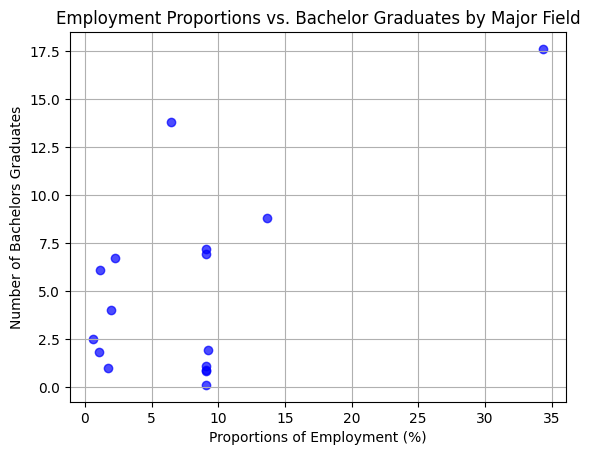

In [78]:
%pip install matplotlib
import matplotlib.pyplot as plt

asu_data = colleges[(colleges['Year'] == 2014) & (colleges['College'] == 'asu')]
job_2014 = jobs[(jobs['Year'] == 2014) & (jobs['Area'] == "Winston-Salem, NC")]
job_2014 = job_2014[job_2014['Occupation Group'] == 'major']
job_2014['Proportions'] *= 100
job_2014 = sum_employment_by_major(job_2014)
combined_df = pd.merge(job_2014, asu_data, on='Major Field')
print(combined_df)
print(spearmanr(combined_df['Proportions'], combined_df['Bachelors']))

plt.scatter(combined_df['Proportions'], combined_df['Bachelors'], color='blue', alpha=0.7)
plt.xlabel('Proportions of Employment (%)')
plt.ylabel('Number of Bachelors Graduates')
plt.title('Employment Proportions vs. Bachelor Graduates by Major Field')
plt.grid(True)
plt.show()